# The notebook for feature_extracting and clustering

## Understand the dataset

In [86]:
import pandas as pd
# error_bad_lines = False means that I skip the noisy lines
filename = 'in_cookie'
df = pd.read_csv(filename,sep = ',',error_bad_lines = False)
print(df.head())
# select some useful features
df = df[['domain_id','domain','http_only','is_3p','name','secure','session','size','is_set_by_response']]

   id  page_id  domain_id        domain  expires_text  \
0   1        1        167  .zerodha.com  1.619815e+09   
1   2        1        167  .zerodha.com  1.680295e+09   
2   3        1        167  .zerodha.com  1.617309e+09   
3   4        1        167  .zerodha.com  1.617223e+09   
4   5        1        167   zerodha.com  1.617309e+09   

               expires_timestamp http_only is_3p  is_1p_3p      name path  \
0  2021-04-30 20:36:40.794387+00         t     f       NaN  __cfduid    /   
1         2023-03-31 20:36:41+00         f     f       NaN       _ga    /   
2         2021-04-01 20:36:41+00         f     f       NaN      _gid    /   
3         2021-03-31 20:37:41+00         f     f       NaN      _gat    /   
4         2021-04-01 20:36:41+00         f     f       NaN       ref    /   

  same_site secure session  size                                        value  \
0       Lax      f       f    51  d8e98e72138a8abc7c1cd7da3d66263cc1617223000   
1       NaN      f       f    29

In [87]:
#  cookie num of domain_id
df.groupby('domain_id').count().reindex().head()

,domain,http_only,is_3p,name,secure,session,size,is_set_by_response
domain_id,,,,,,,,
1,3,3,3,3,3,3,3,3
2,1,1,1,1,1,1,1,1
167,5,5,5,5,5,5,5,5
214,680,680,680,680,680,680,680,680
216,1,1,1,1,1,1,1,1


In [88]:
# domain_count
print(len(df['domain_id'].unique()))
# cookies num
print(len(df['name'].unique()))

1925
5075


## Preprocessing  the dataset

In [89]:
cookie_name_dump = pd.get_dummies(df['name'])
is_3p_dump = pd.get_dummies(df['is_3p'])
secure_dump = pd.get_dummies(df['secure'])
session_dump = pd.get_dummies(df['session'])
set_by_response_dump = pd.get_dummies(df['is_set_by_response'])

cookie_domain_set = pd.concat([df['size'],df['domain_id'],cookie_name_dump,is_3p_dump,secure_dump,session_dump,set_by_response_dump],axis = 1)

# del cookie_name_dump['name']
# del cookie_name_dump['is_3p']
# del cookie_name_dump['secure']
# del cookie_name_dump['session']
# del cookie_name_dump['is_set_by_response']

print(cookie_domain_set.head())

   size  domain_id  $FC_Register_cookies$  .ASPXANONYMOUS  .c  \
0    51        167                      0               0   0   
1    29        167                      0               0   0   
2    31        167                      0               0   0   
3     5        167                      0               0   0   
4    10        167                      0               0   0   

   05c5a38e3b061190d573779b0b75591e  0d269e8747  10_lang  \
0                                 0           0        0   
1                                 0           0        0   
2                                 0           0        0   
3                                 0           0        0   
4                                 0           0        0   

   14c99d47e3e2ee047147ab253f9e68ae  15bbf1ab6e47faadecba0abdd65302f7  ...  \
0                                 0                                 0  ...   
1                                 0                                 0  ...   
2             

## normalization

In [90]:
from sklearn import preprocessing
cookie_values = cookie_domain_set.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(cookie_values)
cookie_scaled = pd.DataFrame(x_scaled,columns=cookie_domain_set.columns)
print(cookie_scaled.head())

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
       size  domain_id  $FC_Register_cookies$  .ASPXANONYMOUS   .c  \
0  0.013492   0.000262                    0.0             0.0  0.0   
1  0.007555   0.000262                    0.0             0.0  0.0   
2  0.008095   0.000262                    0.0             0.0  0.0   
3  0.001079   0.000262                    0.0             0.0  0.0   
4  0.002428   0.000262                    0.0             0.0  0.0   

   05c5a38e3b061190d573779b0b75591e  0d269e8747  10_lang  \
0                               0.0         0.0      0.0   
1                               0.0         0.0      0.0   
2                               0.0         0.0      0.0   
3                               0.0         0.0      0.0   
4                               0.0         0.0      0.0   

   14c99d

### dimension reduction

In [91]:
from sklearn.decomposition import PCA
pca = PCA(2)
print(cookie_scaled.shape)
pca_data = pca.fit_transform(cookie_scaled)
print(pca_data.shape)

(32377, 5084)
(32377, 2)


## Modeling

In [92]:
from sklearn.cluster import KMeans

kmeans = KMeans(10)
kfit = kmeans.fit(pca_data)
identified_clusters = kfit.predict(pca_data)

print(identified_clusters)
print(len(identified_clusters))

[8 1 1 ... 0 1 5]
32377


## plot the picture

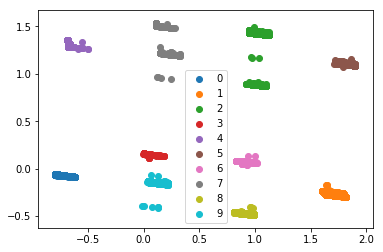

In [93]:
import matplotlib.pyplot as plt 
import numpy as np 
u_labels = np.unique(identified_clusters)

for i in u_labels:
    plt.scatter(pca_data[identified_clusters == i, 0],pca_data[identified_clusters == i, 1],label = i)
plt.legend()
plt.savefig(filename)
plt.show()


## data view

In [94]:
clustered_data_scaled = df.copy()
clustered_data_scaled['Cluster'] = identified_clusters

df_sort = clustered_data_scaled.sort_values(by = 'Cluster')

for i in u_labels:
    print(df_sort[df_sort['Cluster'] == i].head())


       domain_id                      domain http_only is_3p  \
16188       9311                  .yahoo.com         f     t   
17725       5730               .pubmatic.com         f     t   
17724       5730               .pubmatic.com         f     t   
17723       5730               .pubmatic.com         f     t   
17722       9855  .targeting.unrulymedia.com         t     t   

                   name secure session  size is_set_by_response  Cluster  
16188            APIDTS      t       f    16                  t        0  
17725  chkChromeAb67Sec      t       f    17                  t        0  
17724    KRTBCOOKIE_594      t       f   118                  t        0  
17723              PugT      t       f    14                  t        0  
17722           _rxuuid      t       f    78                  t        0  
       domain_id                  domain http_only is_3p  \
22654     454745           .hdfcergo.com         f     f   
539        10012            .freepik.com     